In [1]:


import os
import time
import cv2
import pandas as pd
import mplfinance as mpf
import matplotlib.pyplot as plt
from ohlc_api import mexi
import plotly.graph_objects as go
from colorama import Fore, Style, init

# Jorunal images for better visulization

# Kucoin or BINGX chart
def chart_image(ticker, timeframe, path, background_color="#f0f0f0"):
    # Get data using mexi
    df = mexi(ticker=ticker, limit=100,timeframe=timeframe)


    df = df.iloc[-150:]

    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    # Customizing the style to remove x and y axes and make the chart bigger
    mc = mpf.make_marketcolors(up='g', down='r')  # Green for up, Red for down
    s = mpf.make_mpf_style(marketcolors=mc, gridcolor='white', y_on_right=False)

    # Plot the candlestick chart using mplfinance
    fig, axes = mpf.plot(df, 
                         type='candle', 
                         style=s, 
                         title=f"{ticker} Candlestick Chart", 
                         ylabel='Price (USDT)', 
                         ylabel_lower='Volume', 
                         returnfig=True,  # Return the figure and axes
                         figsize=(10, 6))  # Make the chart bigger

    # Set the background color of the figure
    fig.patch.set_facecolor(background_color)

    # Remove the x-axis and y-axis
    for ax in axes:
        ax.xaxis.set_visible(False)  
        ax.yaxis.set_visible(False)  

    # Save the chart as an image
    fig.savefig(f'{path}.jpg', bbox_inches='tight', pad_inches=0.1, transparent=True)


def image_exists(directory, image_name):
    """Checks if a specific image file exists in the given directory."""
    file_path = os.path.join(directory, image_name)
    does_exist_file =  os.path.isfile(file_path)

    return does_exist_file; 
    # if does_exist_file :
    #     print(f"{Fore.GREEN} Success => {Fore.WHITE} {image_name} does exist...")
    # else:
    #     print(f"{Fore.RED} Failded => {Fore.WHITE} {image_name} does not EXIST...")


def combine_images(ticker,directory_img,target_image_path):
    image_path = directory_img
    # original_image = main_image_path
    # Load the images
    main_image_path = f'{image_path}\{target_image_path}.jpg'
    
    second_image_name =  ticker+"_5.jpg"
    third_image_name =  ticker+"_15.jpg"

    # 5_min timeframe image
    if  not image_exists(directory=image_path,image_name=second_image_name):
        print(f"{second_image_name} {Fore.RED} does not EXIST {Fore.WHITE}, Creating one...")
        chart_image(ticker=ticker, timeframe=5, path=f'{image_path}\FIL_5', background_color='#d3d1c1') 
    else: 
        print(f"{second_image_name} {Fore.GREEN} Exist. {Fore.WHITE}, Pick that one...")


    # 15_min timeframe image
    if  not image_exists(directory=image_path,image_name=third_image_name):
        print(f"{third_image_name} {Fore.RED} does not EXIST {Fore.WHITE}, Creating one...")
        chart_image(ticker=ticker, timeframe=15, path=f'{image_path}\FIL_15', background_color='#d3d1c1') 
    else: 
        print(f"{third_image_name} {Fore.GREEN} Exist {Fore.WHITE}, Pick that one...")

    five_m_image = f'{image_path}\FIL_5.jpg'
    
    fifhteen_m_image = f'{image_path}\FIL_15.jpg'

    if not all([os.path.exists(main_image_path), os.path.exists(five_m_image), os.path.exists(fifhteen_m_image)]):
        print("Error: One or more image files are missing. Check the paths.")
        exit()
    main_image = cv2.imread(main_image_path)
    small_image1 = cv2.imread(five_m_image)
    small_image2 = cv2.imread(fifhteen_m_image)

    # Resize smaller images to 500x200
    small_image1 = cv2.resize(small_image1, (500, 200))
    small_image2 = cv2.resize(small_image2, (500, 200))

    # Get dimensions of the main image
    main_h, main_w, _ = main_image.shape

    # Define positions for placing the smaller images
    position1 = (main_h - 200, 20)  # Bottom-left corner for the first image
    position2 = (main_h - 200, 240)  # Bottom-left corner for the second image with a gap

    # Add horizontal space between the two images by adjusting the second image's position
    gap_between_images = 100  # Increase or decrease this value to adjust the space

    # Adjust position of the second image
    position2 = (position2[0], position2[1] + gap_between_images)  # Move the second image horizontally

    # Overlay smaller images
    main_image[position1[0]:position1[0] + 200, position1[1]:position1[1] + 500] = small_image1
    main_image[position2[0]:position2[0] + 200, position2[1]:position2[1] + 500] = small_image2

    # Add styled text
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    font_color = (0, 0, 0)  # Black text color
    font_thickness = 2

    # Add a background rectangle behind the text for better visibility
    def add_text_with_background(image, text, org, font, font_scale, font_color, font_thickness, bg_color):
        # Get text size
        text_size = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
        text_x, text_y = org
        box_coords = ((text_x - 5, text_y - text_size[1] - 5), (text_x + text_size[0] + 5, text_y + 5))
        
        # Draw background rectangle
        cv2.rectangle(image, box_coords[0], box_coords[1], bg_color, cv2.FILLED)
        
        # Draw text on top of the rectangle
        cv2.putText(image, text, (text_x, text_y), font, font_scale, font_color, font_thickness)

    # Add text with background to each image
    add_text_with_background(main_image, "1_min", (25, main_h - 210), font, font_scale, font_color, font_thickness, bg_color=(255, 255, 255))  # White background
    add_text_with_background(main_image, "5_min", (245, main_h - 210), font, font_scale, font_color, font_thickness, bg_color=(255, 255, 255))  # White background

    # Save or display the resulting image

    #  Delete the unuseful images
    os.remove(five_m_image)
    os.remove(fifhteen_m_image)

    cv2.imwrite(
    rf"C:\Users\Markazi.co\Videos\Movavi Screen Recorder\MIX\{ticker}_{time.strftime('%Y%m%d_%H%M%S')}.jpg",
    main_image
)

    cv2.imshow('Result', main_image)
    # cv2.waitKey(0)
    cv2.destroyAllWindows()


# combine_images(ticker='FIL',directory_img=r"C:\Users\Markazi.co\Videos\Movavi Screen Recorder",target_image_path='Screenshot 01-04-2025 18.39.26')
               



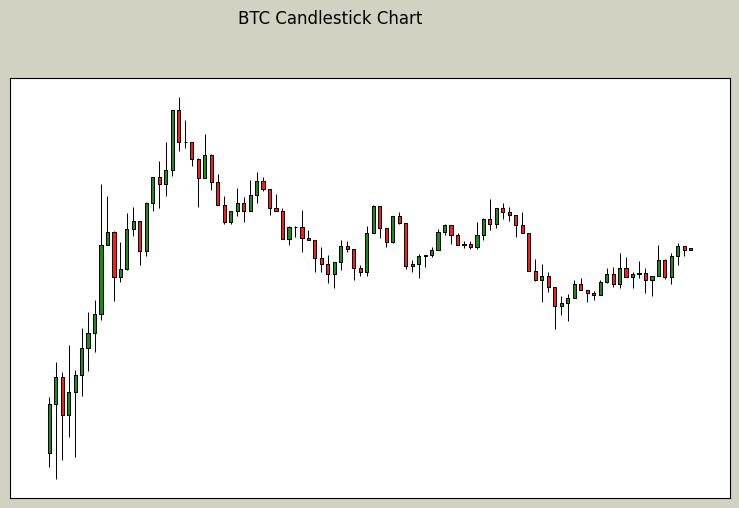

In [5]:
def chart_image(ticker, timeframe, path, background_color="#f0f0f0"):
    # Get data using mexi
    df = mexi(ticker=ticker, limit=100,timeframe=timeframe)

    df = df.iloc[-150:]

    df['Time'] = pd.to_datetime(df['Time'])
    df.set_index('Time', inplace=True)

    # Customizing the style to remove x and y axes and make the chart bigger
    mc = mpf.make_marketcolors(up='g', down='r')  # Green for up, Red for down
    s = mpf.make_mpf_style(marketcolors=mc, gridcolor='white', y_on_right=False)

    # Plot the candlestick chart using mplfinance
    fig, axes = mpf.plot(df, 
                         type='candle', 
                         style=s, 
                         title=f"{ticker} Candlestick Chart", 
                         ylabel='Price (USDT)', 
                         ylabel_lower='Volume', 
                         returnfig=True,  # Return the figure and axes
                         figsize=(10, 6))  # Make the chart bigger

    # Set the background color of the figure
    fig.patch.set_facecolor(background_color)

    # Remove the x-axis and y-axis
    for ax in axes:
        ax.xaxis.set_visible(False)  
        ax.yaxis.set_visible(False)  

    # Save the chart as an image
    fig.savefig(f'{path}.jpg', bbox_inches='tight', pad_inches=0.1, transparent=True)


path =r'C:\Users\Markazi.co\Videos\Movavi Screen Recorder'
chart_image(ticker='BTC', timeframe=15, path=f'{path}\FIL_15', background_color='#d3d1c1') 

In [9]:
def plot_with_signals(utils, data, total_result):
    import plotly.graph_objects as go
    import numpy as np

    # Plotting the chart with customization config
    fig = go.Figure()

    # Add candlestick chart
    fig.add_trace(go.Candlestick(
        x=data.index,
        open=data['Open'],
        high=data['High'],
        low=data['Low'],
        close=data['Close'],
        name='Candlestick',
        increasing_line_color='green',
        decreasing_line_color='red'
    ))  

    # Trace for Ichimoku Cloud (Span A and Span B)
    fig.add_trace(go.Scatter(x=data.index, y=data['span_A'],
                             mode='lines', marker=dict(color='rgba(128, 128, 128, 0.3)', size=1), showlegend=True, name='Span A'))

    fig.add_trace(go.Scatter(x=data.index, y=data['span_B'],
                             mode='lines',
                             marker=dict(size=0.1, color='rgba(128, 128, 128, 0.3)'),
                             fill='tonexty',
                             fillcolor='rgba(128, 128, 128, 0.3)',  # Fill color
                             name='Span B'))

    # Add vertical lines for LONG and SHORT signals
    for index, row in total_result.iterrows():
        line_color = 'green' if row['type'] == 'LONG' else 'red'  # Green for LONG, Red for SHORT

        # Add vertical line at `cross_span_date`
        fig.add_shape(
            type="line",
            x0=row['cross_span_date'],
            x1=row['cross_span_date'],
            y0=data['Close'].min(),
            y1=data['Close'].max(),
            line=dict(color=line_color, width=1, dash="dash"),
            xref="x", yref="y"
        )

    # Chart Layout
    fig.update_layout(
        xaxis_rangeslider_visible=False,
        title='Candlestick Chart with LONG and SHORT Signals',
        xaxis_title='Date',
        yaxis_title='Price',
        plot_bgcolor='white',
        width=1600,
        height=600,
        showlegend=True
    )

    return fig

# Call the function
fig = plot_with_signals(utils=obj.utils,data=data,total_result=Total_result)
fig.show()


NameError: name 'obj' is not defined

In [2]:
import time
import ccxt

# Initialize the exchange (using Binance in this example)
exchange = ccxt.binance()

# Define the watch list with target prices
watch_list = {
    "BTC/USDT": 20000,  # Example: Trigger when BTC/USDT hits 20,000
    "ETH/USDT": 1500,   # Example: Trigger when ETH/USDT hits 1,500
    "XRP/USDT": 0.5     # Example: Trigger when XRP/USDT hits 0.5
}

def check_prices():
    """Fetches current prices and checks against target prices."""
    triggered = []
    for ticker, target_price in watch_list.items():
        try:
            # Fetch ticker price
            ticker_data = exchange.fetch_ticker(ticker)
            current_price = ticker_data['last']

            # Check if target price is triggered
            if current_price >= target_price:
                print(f"[TRIGGERED] {ticker} has reached the target price: {target_price} (Current: {current_price})")
                triggered.append(ticker)
            else:
                print(f"[CHECK] {ticker} is at {current_price}, below the target {target_price}.")
        except Exception as e:
            print(f"Error fetching price for {ticker}: {e}")

    # Remove triggered tickers from the watch list
    for ticker in triggered:
        del watch_list[ticker]
        print(f"[REMOVED] {ticker} has been removed from the watch list.")

# if __name__ == "__main__":
#     print("Starting cryptocurrency price monitoring...")
#     while watch_list:
#         print("\nChecking prices...")
#         check_prices()
#         print("\nWaiting for 1 minute before the next check...")
#         time.sleep(60)  # Wait for 1 minute

#     print("All target prices have been triggered. Monitoring complete!")


In [6]:

#  Plotting some charts wiht different data input of ohlc

from ohlc_api import  kucoin_data,mexi
import plotly.graph_objects as go

from ta import momentum

ticker=  "LPT"
fig = go.Figure()

data = kucoin_data(symbol=ticker,num_timeframe=5,format_timeframe='min',past_time=100)
# data = mexi(ticker=ticker,limit=10000,timeframe=1)

data['rsi'] =momentum.rsi(data.Close,window= 14)

data.head(1)

,Time,Open,Close,High,Low,Volume,CloseTime,Symbol,rsi
Time,,,,,,,,,
2025-01-20 08:35:00+03:30,2025-01-20 08:35:00+03:30,12.3934,12.4866,12.5156,12.3934,20.493,255.595241,LPT-USDT,NaN


In [7]:

from hashlib import sha256
import requests
import pandas as pd

ticker= "LPT"


fig= go.Figure()

# fig.add_trace(go.Scatter(x=data.index,y= data['rsi']))
fig.add_trace(go.Candlestick(
        x=data.index,
        open=data["Open"],high=data['High'],
        low=data['Low'],close=data['Close'],name='Candlestick',
        increasing_line_color='green',decreasing_line_color='red'
    ))  




"Error: name 'hmac' is not defined"